In [4]:
"""
Here we study whether we are able to detect assymetric market returns (fatter tail into the 
losses than into gains) for the S&P 500 historical returns.

We assume a model (effectively Laplace distribution with unequal decay constants on the two sides of the mean)

    p(x) = exp(-|x-mu|/bLeft) /(bLeft + bRight) if x < mu
    p(x) = exp(-|x-mu|/bRight)/(bLeft + bRight) if x > mu


As we are interested in confidence of our result, we perform MCMC to get error bars.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load data

In [5]:
data = pd.read_csv('SPX.csv', parse_dates = ['Date'], index_col = 0)

data['Pct_change'] = data['Adj Close'].pct_change()   # p2/p1 - 1
data['Log_change'] = np.log(1 + data['Pct_change'])    # Log(p2/p1)

print(data.head())

                 Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
1927-12-30  17.660000  17.660000  17.660000  17.660000  17.660000       0   
1928-01-03  17.760000  17.760000  17.760000  17.760000  17.760000       0   
1928-01-04  17.719999  17.719999  17.719999  17.719999  17.719999       0   
1928-01-05  17.549999  17.549999  17.549999  17.549999  17.549999       0   
1928-01-06  17.660000  17.660000  17.660000  17.660000  17.660000       0   

            Pct_change  Log_change  
Date                                
1927-12-30         NaN         NaN  
1928-01-03    0.005663    0.005647  
1928-01-04   -0.002252   -0.002255  
1928-01-05   -0.009594   -0.009640  
1928-01-06    0.006268    0.006248  


In [6]:
# Values of daily logaritmic changes as a numpy array. Ignore the first value (NaN)
x = data['Log_change'].values[1:]

# Asymmetric Laplace distribution

In [7]:
def minus_log_likelihood(mu, bLeft, bRight):
    """
    Given the observed log returns x, what is negative log likelihood? Assume the probability density
    function is given by
    p(x) = exp(-|x-mu|/bLeft) /(bLeft + bRight) if x < mu
    p(x) = exp(-|x-mu|/bRight)/(bLeft + bRight) if x > mu
    """
    
    return np.sum(np.abs(x-mu)/np.abs(bLeft)*(x < mu) 
                  + np.abs(x-mu)/np.abs(bRight)*(x >= mu) 
                  + np.log(np.abs(bLeft) + np.abs(bRight))
                 )


# MCMC

We could do a fit as before (we perform it as a sanity check below), but that way would not give us error bars.

In [9]:
# MCMC skeleton from
# https://gregorygundersen.com/blog/2019/11/02/metropolis-hastings/

import numpy as np
from   numpy.random import multivariate_normal as mvn
import matplotlib.pyplot as plt

n_iters    = 30000
samples    = np.empty((n_iters, 3))
samples[0] = [0.00048244, 0.00761927, 0.00761927] # results of previous notebook

for i in range(1, n_iters):
    curr  = samples[i-1]
    prop  = curr + mvn(np.zeros(3), np.diag([1e-10, 1e-10, 1e-10]))
    alpha = np.exp(-minus_log_likelihood(*prop) + minus_log_likelihood(*curr))
    if np.random.uniform() < alpha:
        curr = prop
    samples[i] = curr

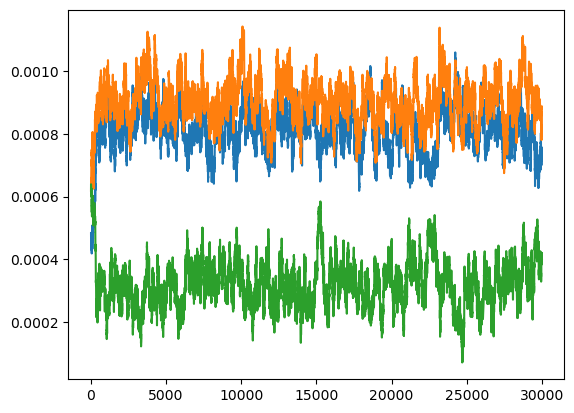

In [16]:
# estimate burn-in by checking the beginning of the chains
plt.plot(samples[:, 0])
plt.plot(samples[:, 1] - 0.007)
plt.plot(samples[:, 2] - 0.007)

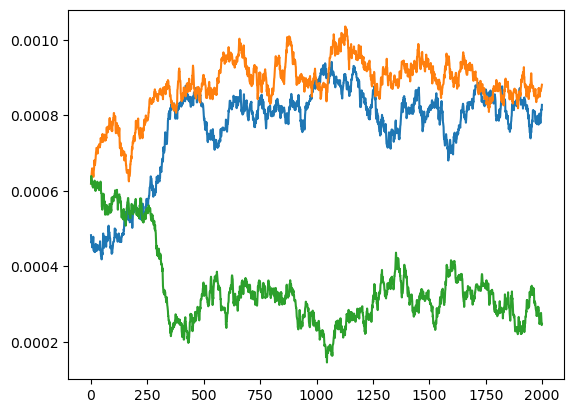

In [18]:
# estimate burn-in by checking the beginning of the chains - zoom in
plt.plot(samples[:2000, 0])
plt.plot(samples[:2000, 1] - 0.007)
plt.plot(samples[:2000, 2] - 0.007)

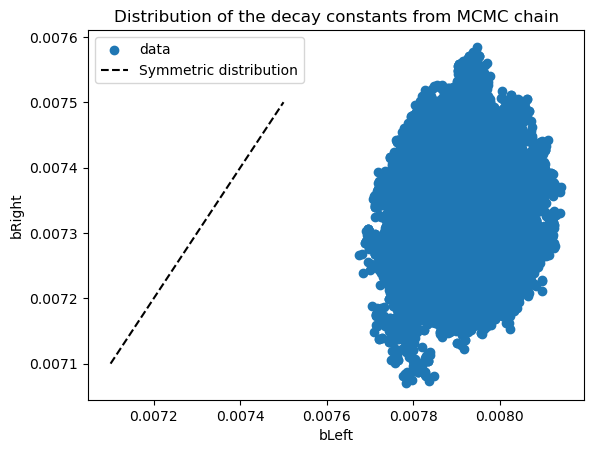

In [22]:
burn_in = 1000 # this should be enough, given the image above

plt.scatter(samples[burn_in:,1],samples[burn_in:,2], label = 'data')
plt.plot([0.0071, 0.0075], [0.0071, 0.0075], 'k--', label = 'Symmetric distribution')
plt.legend()
plt.xlabel('bLeft')
plt.ylabel('bRight')
plt.title('Distribution of the decay constants from MCMC chain');

We clearly see a deviation from symmetry

In [27]:
print(f'Mean bLeft  is {np.mean(samples[burnout:,1]):.4f}')
print(f'Mean bRight is {np.mean(samples[burnout:,2]):.4f}')

Mean bLeft  is 0.0079
Mean bRight is 0.0073


In [33]:
diff = samples[burnout:,1] - samples[burnout:,2]
print(f'Mean bLeft - bRight is {np.mean(diff):.1e} and standard deviation {np.std(diff):.1e}')

Mean bLeft - bRight is 5.9e-04 and standard deviation 9.6e-05


# Sanity check

As a sanity check, we compare the means obtained in previous section with regular function minimization

In [34]:
def minus_log_likelihoodB(pars, x):
    """
    Given the observed log returns x, what is negative log likelihood? Assume the probability density
    function is given by
    p(x) = exp(-|x-mu|/bLeft) /(bLeft + bRight) if x < mu
    p(x) = exp(-|x-mu|/bRight)/(bLeft + bRight) if x > mu
    and pars = (mu, bLeft, bRight)
    """
    mu, bLeft, bRight = pars
    return np.sum(np.abs(x-mu)/np.abs(bLeft)*(x < mu) 
                  + np.abs(x-mu)/np.abs(bRight)*(x >= mu) 
                  + np.log(np.abs(bLeft) + np.abs(bRight))
                 )

In [35]:
fit_coef = minimize(minus_log_likelihoodB, [0,0.01, 0.01], data['Log_change']).x
print(fit_coef)

[0.00082068 0.007911   0.00731642]


Ok, so we got sensible numbers from our MCMC

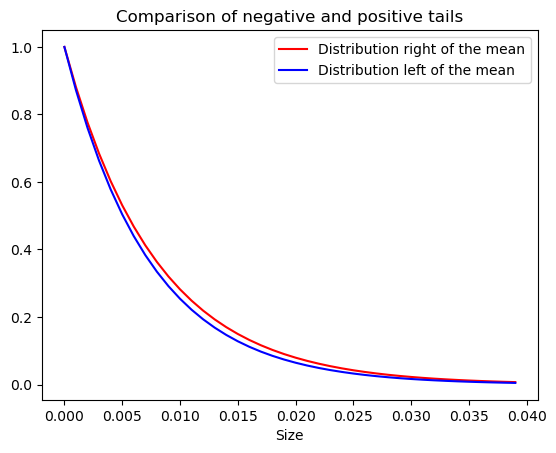

In [39]:
x = np.arange(0,0.04,0.001)
plt.plot(x,np.exp(-x/0.0079), color = 'r', label = 'Distribution right of the mean')
plt.plot(x,np.exp(-x/0.0073), color = 'b', label = 'Distribution left of the mean')
plt.legend()
plt.xlabel('Size')
plt.title('Comparison of negative and positive tails');

So indeed, there is a statistically significant detection of faster decay towards the losses. However, the expected value of S&P 500 is still positive, because the difference is smaller than the mean.

Indeed, 
    $$\int_0^\infty x e^{-x/b} = b^2$$
and we happen to have
    $$0 < -\frac{b_\mathrm{left}^2}{b_\mathrm{left} + b_\mathrm{right}} + \frac{b_\mathrm{right}^2}{b_\mathrm{left} + b_\mathrm{right}} + \mu$$
